# **STANDARD NOTEBOOK TO GET RESULTS**

## 1. Clean the Data

In [1]:
import pandas as pd 
import process
import numpy as np 
# Jerome path : r'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DataBase.csv'
# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv'
df = pd.read_csv(r'/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv')

df.set_index('ticker', inplace=True)

df.columns = pd.to_datetime(df.columns.str[1:], format='%Y%m%d').strftime('%d/%m/%Y')

df_cleaned = df.fillna(0) # Utilisez la méthode fillna(0) pour remplacer les NaN par 0

df_cleaned = df_cleaned.transpose() ## WE WANT COLUMNS TO BE VECTOR OF RETURN FOR A GIVEN TICKER

In [23]:
(4771 - 4021)/5

150.0

In [26]:
df_cleaned.iloc[4021:4251, :]

ticker,AA,ABM,ABT,ADI,ADM,ADX,AEE,AEG,AEM,AEP,...,XLI,XLK,XLP,XLU,XLV,XLY,XOM,XRX,YUM,ZTR
04/01/2016,0.019761,-0.013996,-0.023254,0.003681,-0.007505,0.003948,-0.002321,0.005410,-0.002225,0.008782,...,0.003640,0.004980,0.000401,0.003711,-0.000565,0.000521,-0.000516,-0.010623,0.012402,0.000826
05/01/2016,-0.047402,0.000000,-0.000932,-0.012687,0.011657,0.001575,0.012015,0.007353,0.023444,0.009568,...,0.000191,-0.005676,0.003994,0.007615,0.001972,-0.002213,0.011976,-0.001944,-0.011045,0.000000
06/01/2016,-0.044300,0.002567,0.005891,-0.025381,-0.010130,0.003992,0.013324,0.005592,0.017373,0.010216,...,-0.001742,0.002404,0.006622,0.004154,0.006119,0.004882,0.010772,0.001972,0.004344,-0.000832
07/01/2016,-0.014406,-0.004481,-0.003365,-0.000595,-0.011234,-0.011401,0.008704,0.000000,0.034948,-0.002054,...,-0.011284,-0.009360,-0.000809,0.004182,-0.001013,-0.000672,0.002233,-0.008073,-0.010512,-0.005034
08/01/2016,-0.054263,-0.011223,-0.028840,-0.015092,-0.010701,-0.014815,-0.008468,-0.023034,0.016028,-0.001544,...,-0.019716,-0.016574,-0.014179,-0.001159,-0.021093,-0.018841,-0.021982,-0.035846,-0.016014,-0.002531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22/11/2016,0.007687,-0.002473,-0.034059,-0.002193,-0.008012,-0.008775,0.010371,0.005797,-0.014171,-0.002532,...,0.001778,-0.000208,0.002155,0.003413,-0.014115,0.008744,-0.000115,-0.021255,0.011383,0.002661
23/11/2016,0.016318,-0.001362,0.024410,-0.001087,-0.007372,0.000802,0.004493,0.005877,-0.023811,0.003065,...,0.005144,-0.003342,-0.001573,0.004095,0.020731,0.002661,0.004381,-0.005379,0.010666,0.001776
25/11/2016,0.014617,0.009973,0.002045,0.010159,0.001839,0.003998,0.015523,0.003899,0.008105,0.010944,...,0.002555,0.003548,0.005678,0.012804,0.001008,0.000844,0.004717,0.007491,0.003321,-0.004435
28/11/2016,-0.019892,-0.004503,-0.012314,0.002025,-0.009236,-0.003208,0.018375,-0.007952,0.012168,0.014889,...,-0.004965,0.001667,0.002341,0.016148,-0.005640,-0.005572,-0.005536,0.010582,0.000475,-0.000891


## 2. Run the code

Once the run is completed, you have: 
* the overall return -> overall return
* the PnL associated to the strategy
* the daily PnL associated to the strategy
* the Sharpe Ratio associated to the strategy

In [27]:
import warnings 
from PyFolioC import PyFolioC
warnings.filterwarnings("ignore") ## so that there are no polluting warnings as output of this cell

##################################################################### PARAMETERS #####################################################################
historical_data = df_cleaned
number_of_repetitions = 10
lookback_window = [4021,4251] ## so that the difference is a multiple of 5 --> year 2016
evaluation_window = 5
number_of_clusters = 38
cov_method = 'SPONGE'
sigma = 0.1
eta = 0.1

beta = 0.95
K = 4  # Number of fold for the cross validation
######################################################################################################################################################

##################################################################### PORTFOLIO ######################################################################
portfolio = PyFolioC(number_of_repetitions=number_of_repetitions, historical_data=historical_data, lookback_window=lookback_window, evaluation_window=evaluation_window, number_of_clusters=number_of_clusters, sigma=sigma, eta=eta, short_selling=True, cov_method=cov_method, beta=beta, number_folds=K)



## year 2012-2013 ==> 3016:3265
## year 2018-2019 ==> 4524:4774
## year 2016-2019 ==> 4021:4774

In [28]:
overall_return, PnL, portfolio_value, daily_PnL = portfolio.sliding_window(50) ## 150 --> 3 years

step 1/50, portfolio value: 1.0006
step 2/50, portfolio value: 1.0023
step 3/50, portfolio value: 1.0024
step 4/50, portfolio value: 1.0016
step 5/50, portfolio value: 1.0022
step 6/50, portfolio value: 1.0040
step 7/50, portfolio value: 1.0050
step 8/50, portfolio value: 1.0054
step 9/50, portfolio value: 1.0058
step 10/50, portfolio value: 1.0075
step 11/50, portfolio value: 1.0082
step 12/50, portfolio value: 1.0100
step 13/50, portfolio value: 1.0102
step 14/50, portfolio value: 1.0092
step 15/50, portfolio value: 1.0092
step 16/50, portfolio value: 1.0091
step 17/50, portfolio value: 1.0111
step 18/50, portfolio value: 1.0101
step 19/50, portfolio value: 1.0111
step 20/50, portfolio value: 1.0141
step 21/50, portfolio value: 1.0142
step 22/50, portfolio value: 1.0148
step 23/50, portfolio value: 1.0137
step 24/50, portfolio value: 1.0122
step 25/50, portfolio value: 1.0126
step 26/50, portfolio value: 1.0132
step 27/50, portfolio value: 1.0139
step 28/50, portfolio value: 1.0141
s

## 3. Save the results to csv files (APPLY THE CELLS ONLY ONCE AS IT CREATES 3 FILES !!)

In [30]:
year = '2016'
clustering_method = 'SPONGE_short_selling'

## process.save_to_csv(year=year, clustering_method=clustering_method)

df_daily = pd.DataFrame(daily_PnL, columns=['Daily PnL'])

df_daily.to_csv(f'daily_{year}_{clustering_method}_{evaluation_window}.csv', index=False)

df_PnL = pd.DataFrame(PnL, columns=['PnL'])

df_PnL.to_csv(f'PnL_{year}_{clustering_method}_{evaluation_window}.csv', index=False)

df_overall_return = pd.DataFrame(overall_return.values, columns=['Return'])

df_overall_return.to_csv(f'Overall_return_{year}_{clustering_method}_{evaluation_window}.csv', index=False)

## 4. Get SP500 data for comparison

In [35]:
start_date = '2016-01-01'
end_date = '2016-12-29'

sp500_PnL = process.get_sp500_PnL(start_date, end_date)
print(len(sp500_PnL))
print(len(overall_return))

[*********************100%%**********************]  1 of 1 completed
250
250


## 5. Plot Portfolio Cumulative PnL vs SP500 Cumulative PnL

In [37]:
PnL

array([-6.45e-03, -4.36e-03, -4.69e-03, -3.34e-03,  6.02e-04, -4.24e-03,
       -2.67e-03, -2.65e-03, -1.34e-03,  2.31e-03, -4.21e-03, -1.96e-03,
       -2.45e-03, -1.11e-03,  2.37e-03, -4.39e-03, -2.48e-03, -3.33e-03,
       -1.95e-03,  1.62e-03, -3.46e-03, -2.51e-03, -2.82e-03, -1.61e-03,
        2.22e-03, -2.74e-03, -1.16e-03, -1.32e-03, -9.44e-05,  4.04e-03,
       -1.35e-03, -8.47e-05, -6.09e-04,  9.00e-04,  4.96e-03, -1.04e-03,
        1.18e-03,  5.65e-04,  1.46e-03,  5.37e-03, -3.15e-04,  1.97e-03,
        1.20e-03,  2.24e-03,  5.79e-03,  6.71e-04,  3.23e-03,  2.53e-03,
        3.57e-03,  7.52e-03,  2.20e-03,  3.63e-03,  3.35e-03,  4.50e-03,
        8.20e-03,  2.85e-03,  4.90e-03,  4.65e-03,  6.18e-03,  9.96e-03,
        4.27e-03,  6.49e-03,  5.66e-03,  6.71e-03,  1.02e-02,  3.35e-03,
        5.26e-03,  4.55e-03,  5.84e-03,  9.25e-03,  2.94e-03,  5.22e-03,
        4.60e-03,  6.03e-03,  9.18e-03,  2.89e-03,  4.44e-03,  3.81e-03,
        5.25e-03,  9.12e-03,  3.85e-03,  5.97e-03, 

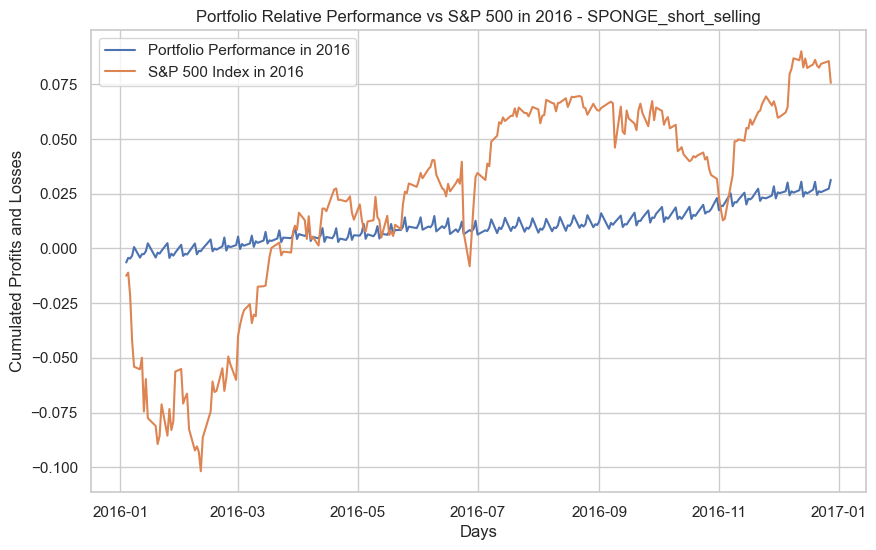

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the cumulative returns
portfolio_cumulative = pd.DataFrame(index = sp500_PnL.index, columns=[f'Portfolio Performance in {year}'], data=PnL)

# Set Seaborn style
sns.set(style="whitegrid")

# Plot the relative performance using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=portfolio_cumulative)
sns.lineplot(data=sp500_PnL.cumsum(), label=f'S&P 500 Index in {year}')
plt.xlabel('Days')
plt.ylabel('Cumulated Profits and Losses')
plt.title(f'Portfolio Relative Performance vs S&P 500 in {year} - {clustering_method}')
plt.legend()
plt.show()

# 6. Plot portfolio value alone

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Création de l'axe des abscisses (nombre de jours)

portfolio_value = pd.DataFrame(index = sp500_PnL.index, columns=[f'Portfolio Value in {year}'], data=portfolio_value)

# Configuration de seaborn pour un style agréable
sns.set(style="whitegrid")

# Tracer la PnL cumulative avec seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(portfolio_value, color='blue')

# Ajouter des titres et des légendes
plt.title(f'Portfolio Value of Time for an Initial Investment of $1 in {year} - {clustering_method}')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')

# Afficher le graphique
plt.show()

ValueError: Shape of passed values is (51, 1), indices imply (251, 1)

# 7. Barplot Daily PnL vs SP500

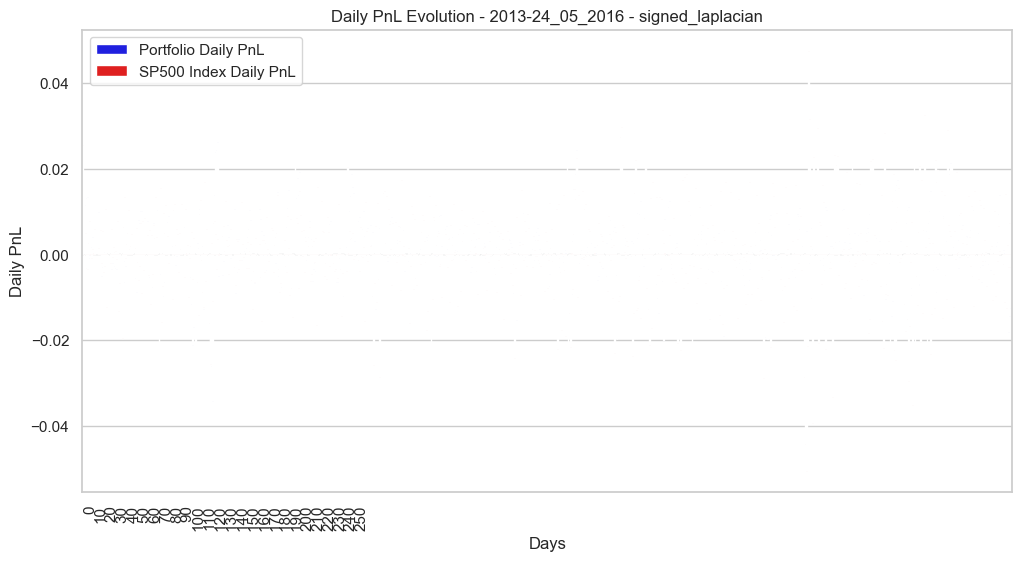

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Création de l'axe des abscisses (nombre de jours)
days = np.arange(1, len(daily_PnL) + 1)

# Configuration de seaborn pour un style agréable
sns.set(style="whitegrid")

# Tracer l'évolution quotidienne de la PnL sous forme de diagramme à barres avec seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=days, y=daily_PnL, color='blue', width=0.8, label='Portfolio Daily PnL')  # Ajustez la largeur ici
ax = sns.barplot(x=days, y=sp500_PnL, color='red', width=0.8, label='SP500 Index Daily PnL')

# Rotation des étiquettes de l'axe des abscisses de 45 degrés avec un ajustement
ax.set_xticks(np.arange(0,251,10))
ax.set_xticklabels(ax.get_xticks(), rotation=90, ha='right', rotation_mode='anchor')

# Ajouter des titres et des légendes
plt.title(f'Daily PnL Evolution - {year} - {clustering_method}')
plt.xlabel('Days')
plt.ylabel('Daily PnL')
plt.legend()

# Afficher le graphique
plt.show()

# 8. Plot everything (SPONGE vs Signed Laplacian vs SP500)

In [73]:
sp500_PnL.iloc[:-2]

Date
2014-01-02   -0.007520
2014-01-03   -0.000997
2014-01-06   -0.003001
2014-01-07    0.004968
2014-01-08   -0.000222
                ...   
2014-12-22    0.005017
2014-12-23    0.000374
2014-12-24   -0.000742
2014-12-26    0.002422
2014-12-29    0.001593
Name: Daily PnL, Length: 250, dtype: float64

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

PnL_SPONGE_5 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2016/PnL_2013-24_05_2016_SPONGE_5_2.csv')
PnL_SPONGE_1 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2018/PnL_2018_SPONGE_1.csv')
PnL_SPONGE_sym_5 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2016/PnL_2013-24_05_2016_SPONGE_sym_5_2.csv')
PnL_SL_5 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2013-2016/PnL_2013-24_05_2016_signed_laplacian_5_2.csv')

#PnL_SPONGE_5_2 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2019/PnL_2019_SPONGE_5_2.csv')
#PnL_SPONGE_sym_5_2 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2019/PnL_2019_SPONGE_sym_5_2.csv')
#PnL_SL_5_2 = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Outputs/2019/PnL_2019_signed_laplacian_5_2.csv')

# Calculate the cumulative returns
portfolio_cumulative_SL_5 = pd.DataFrame(index=sp500_PnL.index, columns=[f'Signed Laplacian Portfolio Performance in {year}'], data=PnL_SL_5.values)
portfolio_cumulative_SPONGE_5 = pd.DataFrame(index=sp500_PnL.index, columns=[f'SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_5.values)
portfolio_cumulative_SPONGE_1 = pd.DataFrame(index=sp500_PnL.index, columns=[f'SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_1.values)
portfolio_cumulative_SPONGE_sym_5 = pd.DataFrame(index=sp500_PnL.index, columns=[f'Symmetric SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_sym_5.values)

# portfolio_cumulative_SL_5_2 = pd.DataFrame(index=sp500_PnL.iloc[:-1].index, columns=[f'Signed Laplacian Portfolio Performance in {year}'], data=PnL_SL_5_2.values)
# portfolio_cumulative_SPONGE_5_2 = pd.DataFrame(index=sp500_PnL.iloc[:-1].index, columns=[f'SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_5_2.values)
# portfolio_cumulative_SPONGE_sym_5_2 = pd.DataFrame(index=sp500_PnL.iloc[:-1].index, columns=[f'Symmetric SPONGE Portfolio Performance in {year}'], data=PnL_SPONGE_sym_5_2.values)

# Combine dataframes for seaborn plotting
## combined_df = pd.concat([portfolio_cumulative_SL_5, portfolio_cumulative_SL_5_2, portfolio_cumulative_SPONGE_5, portfolio_cumulative_SPONGE_5_2, portfolio_cumulative_SPONGE_sym_5, portfolio_cumulative_SPONGE_sym_5_2, sp500_PnL.iloc[:-1].cumsum()], axis=1)
combined_df = pd.concat([portfolio_cumulative_SL_5, portfolio_cumulative_SPONGE_5, portfolio_cumulative_SPONGE_sym_5, sp500_PnL.iloc[:-2].cumsum()], axis=1)
combined_df.columns = [f'Signed Laplacian - Evaluation window {evaluation_window}', f'SPONGE - Evaluation window {evaluation_window}', f'SPONGE_sym - Evaluation window {evaluation_window}', f'S&P 500 Index in {year}']

# Set Seaborn style
sns.set(style="darkgrid")

# Plot the relative performance using Seaborn
plt.figure(figsize=(15, 8))
sns.lineplot(data=combined_df, palette=['blue', 'red', 'orange', 'green'], alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Cumulated Profits and Losses')
plt.title(f'Portfolio Relative Performance vs S&P 500 in {year}')
plt.legend()
plt.show()

ValueError: Shape of passed values is (250, 1), indices imply (855, 1)